In [13]:
import pickle
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

In [ ]:
def financial_data_pipeline(
                            data_path = 'data/Organizational_Data.xlsx',
                            answer2id = {
                                        'A1' : 0,
                                        'A2' : 1,
                                        'A3' : 2,
                                        'A4' : 3,
                                        },
                            level2id = {
                                        'L1' : 0,
                                        'L2' : 1,
                                        'L3' : 2,
                                        'L4' : 3
                                        }
                            ):
    df = pd.read_excel(
                        data_path,
                        sheet_name='Sheet2'
                        )
    df = df.replace(answer2id)
    df = df.replace(level2id)

    Y = df['level'].values
    X = df.drop(columns=['level']).values

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
    Xtrain = np.concatenate([Xtrain, Xtest])
    Ytrain = np.concatenate([Ytrain, Ytest])
    
    return Xtrain, Xtest, Ytrain, Ytest

In [15]:
Xtrain, Xtest, Ytrain, Ytest = financial_data_pipeline()

print("Xtrain.shape", Xtrain.shape)
print("Xtest.shape", Xtest.shape)
print("Ytrain.shape", Ytrain.shape)
print("Ytest.shape", Ytest.shape)

Xtrain.shape (201, 20)
Xtest.shape (41, 20)
Ytrain.shape (201,)
Ytest.shape (41,)


In [16]:
cls_01 = SVC(
            C = 1,
            kernel = 'rbf',
            gamma = 'auto'
            )

cls_02 = XGBClassifier(
                    n_estimators = 100,
                    max_depth = 10
                    )

cls = VotingClassifier(
                    estimators = [
                        ('cls_01', cls_01),
                        ('cls_02', cls_02)
                    ]
                    )

In [17]:
cls.fit(Xtrain, Ytrain)

VotingClassifier(estimators=[('cls_01', SVC(C=1, gamma='auto')),
                             ('cls_02',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [19]:
Ptrain = cls.predict(Xtrain)
Ptest = cls.predict(Xtest)

In [20]:
print("====================== Train CLS REPORT =======================")
clf_report = classification_report(
                                Ytrain,
                                Ptrain,
                                target_names = ['L1', 'L2', 'L3', 'L4']
                                )
print(clf_report)

print("====================== Test CLS REPORT =======================")
clf_report = classification_report(
                                Ytest, 
                                Ptest,
                                target_names = ['L1', 'L2', 'L3', 'L4']
                                )
print(clf_report)

====================== Train CLS REPORT =======================
              precision    recall  f1-score   support

          L1       0.97      1.00      0.98        85
          L2       1.00      0.95      0.98        44
          L3       0.97      1.00      0.98        31
          L4       1.00      0.95      0.97        41

    accuracy                           0.98       201
   macro avg       0.98      0.98      0.98       201
weighted avg       0.98      0.98      0.98       201

====================== Test CLS REPORT =======================
              precision    recall  f1-score   support

          L1       1.00      1.00      1.00        14
          L2       1.00      1.00      1.00         9
          L3       1.00      1.00      1.00        11
          L4       1.00      1.00      1.00         7

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



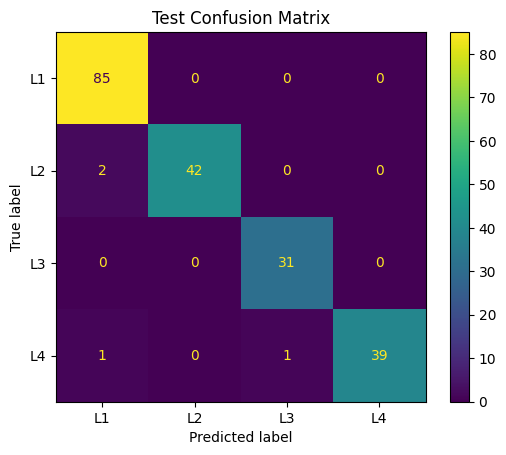

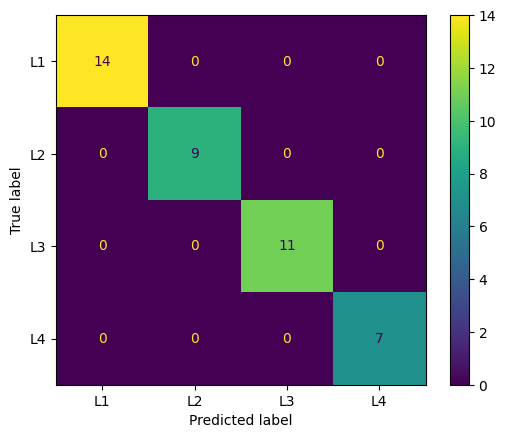

In [21]:
cm_train = confusion_matrix(Ytrain, Ptrain)
cm_test = confusion_matrix(Ytest, Ptest)

disp = ConfusionMatrixDisplay(
                            confusion_matrix = cm_train,
                            display_labels = ['L1', 'L2', 'L3', 'L4']
                            )               
disp.plot()

disp = ConfusionMatrixDisplay(
                            confusion_matrix = cm_test,
                            display_labels = ['L1', 'L2', 'L3', 'L4']
                            )                  
plt.title('Test Confusion Matrix') 
disp.plot()

In [22]:
with open('artifacts/organizational_cls.pkl', 'wb') as f:
    pickle.dump(cls, f)

### inference

In [24]:
with open('artifacts/organizational_cls.pkl', 'rb') as f:
    cls = pickle.load(f)

In [25]:
def predict_level(
                sample_json,
                answer2id = {
                        'A1' : 0,
                        'A2' : 1,
                        'A3' : 2,
                        'A4' : 3,
                        },
                id2level = {
                        0 : 'L1',
                        1 : 'L2',
                        2 : 'L3',
                        3 : 'L4'
                        }
                ):
    
    sample_df = pd.DataFrame([sample_json])
    sample_df = sample_df.replace(answer2id)
    response = cls.predict(sample_df.values)
    level = int(response[0])
    return id2level[level]

In [ ]:
sample_json = {
            'Q1': 'A1',
            'Q2': 'A2',
            'Q3': 'A1',
            'Q4': 'A1',
            'Q5': 'A1',
            'Q6': 'A1',
            'Q7': 'A1',
            'Q8': 'A1',
            'Q9': 'A1',
            'Q10': 'A1',
            'Q11': 'A1',
            'Q12': 'A1',
            'Q13': 'A1',
            'Q14': 'A1',
            'Q15': 'A1',
            'Q16': 'A1',
            'Q17': 'A1',
            'Q18': 'A1',
            'Q19': 'A1',
            'Q20': 'A1',
            }
predict_level(sample_json)

'L1'